# <span style="color:green"> Sparkify Project Workspace </span> </h1>

### Project Overview
This analysis focuses on predicting user churn within a music application using Apache Spark and Python. The project originated from the need to understand user behavior and identify patterns that lead to subscription cancellations. The primary dataset, "medium-sparkify-event-data.json," records every user action within the application. The analysis is conducted in Jupyter Notebook, leveraging the Spark framework.

### Problem Statement
The goal is to develop a predictive model that identifies potential churners based on user interactions. By understanding the features that contribute to churn, the project aims to assist in implementing targeted strategies for user retention.

### Metrics
The project utilizes the F1 score as the primary metric to measure the performance of the predictive models. In a classification problem like churn prediction, F1 score provides a balanced assessment, especially in scenarios with imbalanced classes. It is chosen over accuracy to account for situations where false positives and false negatives hold varying degrees of importance.## Import necessary libraries


In [ ]:
# Install required libraries
#!pip install pyspark
#!pip install matplotlib
#!pip install pandas
#!pip install ipython
#!pip install regex
#!pip install DateTime
#!pip install numpy

In [3]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [4]:
#import ibmos2spark, os

## IBM Cloud Object Storage (COS) credentials
#metadata = {
#    'endpoint': 'https://s3.private.eu-de.cloud-object-storage.appdomain.cloud',
#    'service_id': 'iam-ServiceId-45f608af-e504-4a7b-bace-37aec030b482',
#    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
#    'api_key': '9iYHmxmI7JXEtlA5kxALJOOTDysO7Ifv4edkkcpDc2ym'
#}
#
## COS configuration
#configuration_name = 'os_0b007a47f9e648fa8220dacec0258f51_configs'
#cos = ibmos2spark.CloudObjectStorage(sc, metadata, configuration_name, 'bluemix_cos')


In [5]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, from_unixtime, when, sum, count
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround
from pyspark.sql import Window
from pyspark.sql.window import Window

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator     
from pyspark.ml import Pipeline                                                                                      
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier                     

import pandas as pd                                                                                                          
from IPython.display import display, HTML                                                                               
import re                                                                                                                     
import datetime                                                                                                         
import numpy as np                                                                                           
import matplotlib.pyplot as plt                                                                                  
%matplotlib inline                                                                         

In [6]:
# Create a Spark session
# - `master("local")`: Specifies that Spark should run in local mode using all available cores
# - `appName("Sparkify Project")`: Sets a user-defined name for the application in the Spark UI
# - `config("spark.sql.repl.eagerEval.enabled", True)`: Enables eager evaluation in Spark SQL REPL
#   (Read-Eval-Print Loop), which can improve interactivity in a Jupyter Notebook
# - `getOrCreate()`: Retrieves an existing Spark session or creates a new one if it doesn't exist

spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Project") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()


# <span style="color:green">Import and View Data </span> </h1>


### Sub Part - 1: Import Data

In [7]:
# File path for the Stack Overflow data
# The variable 'stack_overflow_data' holds the name or path of the JSON file
stack_overflow_data = 'mini_sparkify_event_data.json'


In [8]:
# Read JSON data into a Spark DataFrame
# - `spark.read.json(...)`: Reads JSON data and creates a Spark DataFrame
#   The data is loaded from the specified Cloud Object Storage (COS) URL using IBM COS SDK.
#   'stack_overflow_data' is the name or path of the JSON file.
#   'cos.url(...)' constructs the full COS URL using the COS bucket name 'sparkify-donotdelete-pr-r0ihlkw8u9vvbn'.
#user_log = spark.read.json(cos.url(stack_overflow_data, 'sparkify-donotdelete-pr-r0ihlkw8u9vvbn'))
user_log = spark.read.json(stack_overflow_data)
# Persist the DataFrame in memory
# - `user_log.persist()`: Persists the DataFrame in memory, optimizing performance for subsequent operations
#   by avoiding redundant reads from the storage.
user_log.persist()


artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Wind...,30
Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,Boston-Cambridge-...,PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Win...",9
Adam Lambert,Logged In,Colin,M,51,Freeman,282.8273,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Wind...,30
Enigma,Logged In,Micah,M,80,Long,262.71302,free,Boston-Cambridge-...,PUT,NextSong,1538331630000,8,Knocking On Forbi...,200,1538352416000,"""Mozilla/5.0 (Win...",9
Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Fas...,200,1538352676000,Mozilla/5.0 (Wind...,30
The All-American ...,Logged In,Micah,M,81,Long,208.29995,free,Boston-Cambridge-...,PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Win...",9
The Velvet Underg...,Logged In,Micah,M,82,Long,260.46649,free,Boston-Cambridge-...,PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Win...",9
Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old A...,200,1538352899000,Mozilla/5.0 (Wind...,30
NULL,Logged In,Colin,M,54,Freeman,NULL,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,NULL,200,1538352905000,Mozilla/5.0 (Wind...,30
Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Wind...,30


### Sub Part - 2: View Data

In [9]:
# Print the number of entries in the dataset
# - `user_log.count()`: Returns the number of rows in the DataFrame, representing the count of entries in the dataset.
# - `print(...)`: Displays the count in the console.
print("Number of entries in the dataset is {}.".format(user_log.count()))

Number of entries in the dataset is 286500.


In [10]:
# Print the schema of the DataFrame
# - `user_log.printSchema()`: Displays the schema of the DataFrame, providing information about the data types
#   and structure of each column in the dataset.
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [11]:
#Print the first row as example
user_log.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [12]:
#Convert user_log to pandas dataframe to better visualize
user_log_pandas = user_log.toPandas()

### First General Analysis

In [13]:
#Statistics of Numeric Columns
user_log_pandas.describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [74]:
import pandas as pd

# Create a summary table for DataFrame analysis
# - `pd.DataFrame(...)`: Initializes an empty Pandas DataFrame with specified column names.
#   This DataFrame will be used to store information about each column in the user_log_pandas DataFrame.

summary_data = []

# Iterate through each column in the user_log_pandas DataFrame
for column in user_log_pandas.columns:
    # Extract unique values and calculate the count
    unique_values = user_log_pandas[column].unique()
    unique_count = len(unique_values)
    
    # Count the number of null values in the column
    isnull_values = user_log_pandas[column].isnull().sum()
    
    # Append information about the column to the summary_data list
    summary_data.append({
        'Column Name': column,
        'Unique Values': unique_values,
        'Number of Unique Value': unique_count,
        'Number of Null': isnull_values
    })

# Create the summary table DataFrame from the list of dictionaries
summary_table = pd.DataFrame(summary_data)

# Display the summary table
summary_table


,Column Name,Unique Values,Number of Unique Value,Number of Null
0,artist,"[Martha Tilston, Five Iron Frenzy, Adam Lamber...",17656,58392
1,auth,"[Logged In, Logged Out, Cancelled, Guest]",4,0
2,firstName,"[Colin, Micah, Ashlynn, Alexi, None, Warren, A...",190,8346
3,gender,"[M, F, None]",3,8346
4,itemInSession,"[50, 79, 51, 80, 52, 81, 82, 53, 54, 55, 83, 8...",1322,0
5,lastName,"[Freeman, Long, Williams, Warren, None, Miller...",174,8346
6,length,"[277.89016, 236.09424, 282.8273, 262.71302, 22...",14866,58392
7,level,"[paid, free]",2,0
8,location,"[Bakersfield, CA, Boston-Cambridge-Newton, MA-...",115,8346
9,method,"[PUT, GET]",2,0


It seems some users have no userId. We need to look at that users. Let's check which pages they have visited.

In [16]:
# Filter rows with missing userId
users_with_no_id = user_log.filter(col("userId")=="")

# Show the pages visited by users with no userId
pages_visited_by_users_with_no_id = (
    users_with_no_id
    .select("page")
    .distinct()
)
pages_visited_by_users_with_no_id.show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



It can be seen that that users with no userId belongs to user just visiting website or registering users. So in analysis these rows will be removed and assigned to **user_log_valid**.


# <span style="color:green">Data Analysis and Modification of User-log Dataframe</span> </h1>

### Analysis 1: Gender Distribution

In [17]:
# Count the number of unique women and men in the user_log DataFrame
num_of_women = user_log.filter(user_log.gender == 'F').select('userId').dropDuplicates().count()
num_of_men = user_log.filter(user_log.gender == 'M').select('userId').dropDuplicates().count()

# Print the results
print("Number of women: {}.\nNumber of men: {}.".format(num_of_women, num_of_men))


Number of women: 104.
Number of men: 121.


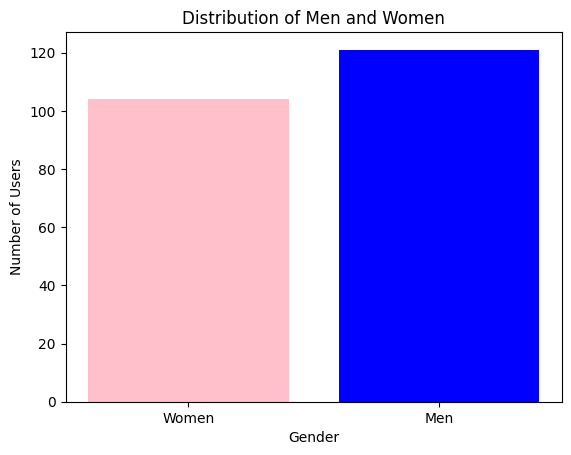

In [18]:
# Matplotlib visualization
labels = ['Women', 'Men']
values = [num_of_women, num_of_men]

plt.bar(labels, values, color=['pink', 'blue'])
plt.title('Distribution of Men and Women')
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.show()

It seems balanced.

### Analysis 2: Unique Number of Users

In [19]:
# - `user_log.select('userId')`: Selects the 'userId' column from the DataFrame.
# - `.dropDuplicates()`: Removes duplicate entries based on the 'userId' column.
# - `.count()`: Counts the number of unique users in the DataFrame.

num_of_unique_users = user_log.select('userId').dropDuplicates().count()

# Print the result
print("Number of unique users is {}.".format(num_of_unique_users))

Number of unique users is 226.


### Analysis 3: Users who downgrade their subscription.

In [20]:
# - `user_log.filter("page = 'Submit Downgrade'")`: Filters the DataFrame to include only rows where the 'page'
#   column has the value 'Submit Downgrade', representing users who have submitted a downgrade.
# - `.count()`: Counts the number of rows in the filtered DataFrame, representing the number of users who
#   have cancelled their account.

num_of_cancelers = user_log.filter("page = 'Submit Downgrade'").count()

# Print the result
print("Number of people who cancelled their account is {}.".format(num_of_cancelers))


Number of people who cancelled their account is 63.


**63 churners and 163 current user. It seems unbalanced. That's why using F1 metrics is a good choice for the analysis of the results.**

### Analysis 4: How many user has no userId?

In [21]:
# - `user_log.groupBy("userId").count()`: Groups the DataFrame by the 'userId' column and counts the number of records
#   for each unique user.
# - `.orderBy("userId")`: Orders the result by 'userId' for better readability.

num_of_records_with_no_id = user_log.groupBy("userId").count().orderBy("userId")

# Print a message indicating the number of records without 'userId'
print("Number of records without userId is:\n")

# Show the first row of the result (assuming the result is ordered by 'userId')
num_of_records_with_no_id.show(1)


Number of records without userId is:

+------+-----+
|userId|count|
+------+-----+
|      | 8346|
+------+-----+
only showing top 1 row



### Analysis 5: Most Popular Pages

In [22]:
# - `user_log.groupBy("page").count()`: Groups the DataFrame by the 'page' column and counts the occurrences of each page.
# - `.orderBy(col("count").desc())`: Orders the result by the count of each page in descending order, placing the
#   most visited pages at the top.

popular_pages = user_log.groupBy("page").count().orderBy(col("count").desc())

# Show the top 10 most visited pages
popular_pages.show(10)

+---------------+------+
|           page| count|
+---------------+------+
|       NextSong|228108|
|           Home| 14457|
|      Thumbs Up| 12551|
|Add to Playlist|  6526|
|     Add Friend|  4277|
|    Roll Advert|  3933|
|          Login|  3241|
|         Logout|  3226|
|    Thumbs Down|  2546|
|      Downgrade|  2055|
+---------------+------+
only showing top 10 rows



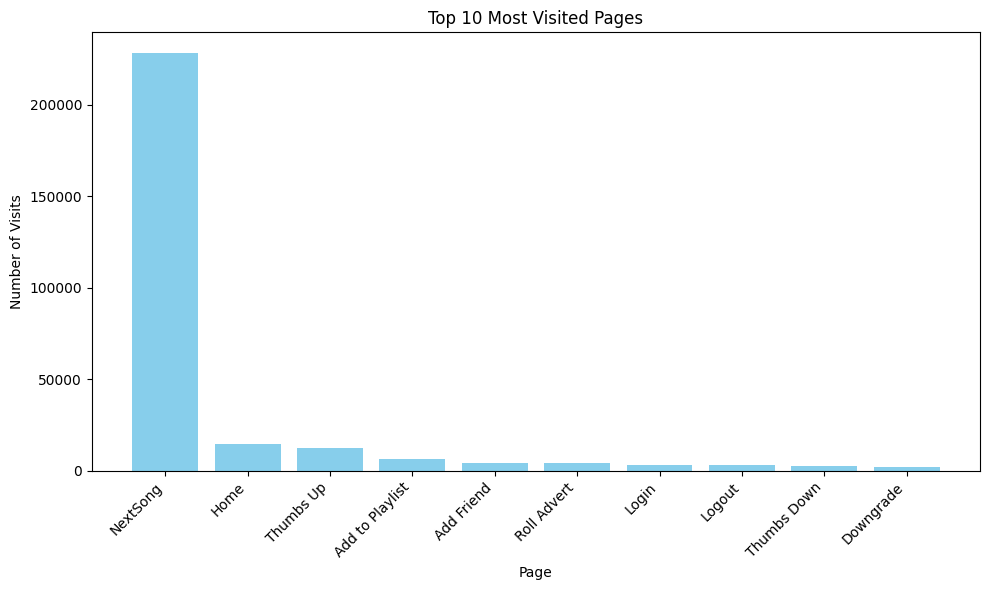

In [23]:
# Convert the PySpark DataFrame to a Pandas DataFrame for visualization
pd_popular_pages = popular_pages.toPandas()

# Matplotlib visualization
plt.figure(figsize=(10, 6))
plt.bar(pd_popular_pages['page'][:10], pd_popular_pages['count'][:10], color='skyblue')
plt.title('Top 10 Most Visited Pages')
plt.xlabel('Page')
plt.ylabel('Number of Visits')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Analysis 6: Number of User Logs vs. States

In [24]:
# - `user_log.groupBy("location").count()`: Groups the DataFrame by the 'location' column and counts the number
#   of occurrences for each state.
# - `.orderBy(col("count").desc())`: Orders the result by the count of user logs in each state in descending order,
#   showing the states with the highest number of user log at the top.

user_location_distribution = user_log.groupBy("location").count().orderBy(col("count").desc())

# Show the top 10 states with the highest number of users
user_location_distribution.show(10)

+--------------------+-----+
|            location|count|
+--------------------+-----+
|Los Angeles-Long ...|30131|
|New York-Newark-J...|23684|
|Boston-Cambridge-...|13873|
|Houston-The Woodl...| 9499|
|                NULL| 8346|
|Charlotte-Concord...| 7780|
|Dallas-Fort Worth...| 7605|
|Louisville/Jeffer...| 6880|
|Philadelphia-Camd...| 5890|
|Chicago-Napervill...| 5114|
+--------------------+-----+
only showing top 10 rows



### Analysis 7: Most Popular Artists

In [25]:
# - `user_log.groupBy("artist").count()`: Groups the DataFrame by the 'artist' column and counts the occurrences
#   of each artist.
# - `.orderBy(col("count").desc())`: Orders the result by the count of listens for each artist in descending order,
#   displaying the most listened-to artists at the top.

popular_artists = user_log.groupBy("artist").count().orderBy(col("count").desc())

# Show the top 10 most listened-to artists
popular_artists.show(10)

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                NULL|58392|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
+--------------------+-----+
only showing top 10 rows



### Analysis 8: Most Popular Browsers

In [26]:
# - `user_log.groupBy("userAgent").count()`: Groups the DataFrame by the 'userAgent' column and counts the occurrences
#   of each user agent.
# - `.orderBy(col("count").desc())`: Orders the result by the count of occurrences for each user agent in descending order,
#   showing the user agents with the highest counts at the top.

user_agent_distribution = user_log.groupBy("userAgent").count().orderBy(col("count").desc())

# Show the top 10 user agents with the highest occurrence counts
user_agent_distribution.show(10)

+--------------------+-----+
|           userAgent|count|
+--------------------+-----+
|"Mozilla/5.0 (Win...|22751|
|"Mozilla/5.0 (Mac...|19611|
|"Mozilla/5.0 (Mac...|18448|
|"Mozilla/5.0 (Mac...|17348|
|Mozilla/5.0 (Wind...|16700|
|"Mozilla/5.0 (Win...|15395|
|"Mozilla/5.0 (Win...|14598|
|Mozilla/5.0 (Maci...|10300|
|"Mozilla/5.0 (iPa...| 8912|
|Mozilla/5.0 (comp...| 8624|
+--------------------+-----+
only showing top 10 rows



Looks like Mozilla has domination on the app.

### Analysis 9: Most Popular Songs

In [27]:
# - `user_log.groupBy("song").count()`: Groups the DataFrame by the 'song' column and counts the occurrences
#   of each song.
# - `.orderBy(col("count").desc())`: Orders the result by the count of listens for each song in descending order,
#   displaying the most listened-to songs at the top.

popular_songs = user_log.groupBy("song").count().orderBy(col("count").desc())

# Show the top 10 most listened-to songs
popular_songs.show(10)

+--------------------+-----+
|                song|count|
+--------------------+-----+
|                NULL|58392|
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
+--------------------+-----+
only showing top 10 rows



### Analysis 10: Hourly Average Listened Music

In [28]:
# Define a user-defined function (UDF) to extract the hour from a timestamp
# - `udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)`: Creates a UDF using a lambda function
#   to convert a timestamp (in milliseconds) to a datetime object and extract the hour.

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

In [29]:
# Add a new column "hour" to the user_log DataFrame
# - `user_log.withColumn("hour", get_hour(user_log.ts))`: Adds a new column named "hour" to the DataFrame by applying
#   the previously defined UDF (`get_hour`) to the 'ts' (timestamp) column.

user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [30]:
# - `user_log.filter(user_log.page == "NextSong")`: Filters the DataFrame to include only rows where the 'page' column
#   has the value "NextSong," representing instances of users playing songs.
# - `.groupby(user_log.hour).count()`: Groups the filtered DataFrame by the 'hour' column and counts the occurrences
#   of songs played in each hour.
# - `.orderBy(user_log.hour.cast("float"))`: Orders the result by the 'hour' column in numerical order.

songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

# Show the top 10 hours with the highest number of songs played
songs_in_hour.show(10)


+----+-----+
|hour|count|
+----+-----+
|   0|10458|
|   1|10122|
|   2| 9630|
|   3| 9062|
|   4| 8388|
|   5| 8336|
|   6| 8355|
|   7| 8147|
|   8| 8178|
|   9| 8054|
+----+-----+
only showing top 10 rows



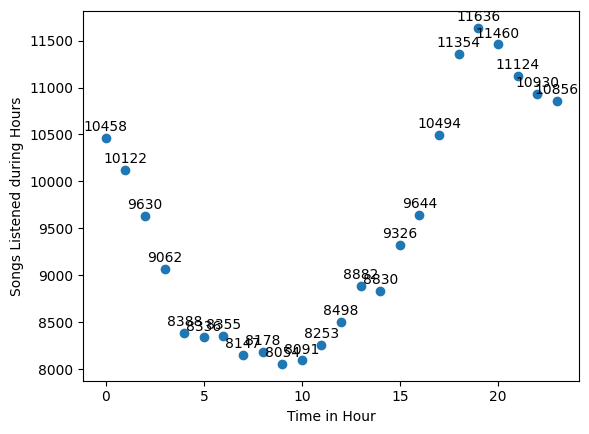

In [31]:
# Convert the songs_in_hour DataFrame to a Pandas DataFrame
# - `songs_in_hour.toPandas()`: Converts the Spark DataFrame 'songs_in_hour' to a Pandas DataFrame.

songs_in_hour_pd = songs_in_hour.toPandas()

# Convert the 'hour' column to numeric type
# - `pd.to_numeric(songs_in_hour_pd.hour)`: Converts the 'hour' column in the Pandas DataFrame to numeric type.

songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

# Create a scatter plot to visualize the distribution of songs played across hours
# - `plt.scatter(...)`: Creates a scatter plot using the 'hour' column as the x-axis and the 'count' column as the y-axis.
# - `plt.xlabel("Hour")`: Sets the x-axis label to "Hour."
# - `plt.ylabel("Songs played")`: Sets the y-axis label to "Songs played."

plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlabel("Time in Hour")
plt.ylabel("Songs Listened during Hours")
# Add data labels to each point on the scatter plot
for i, txt in enumerate(songs_in_hour_pd["count"]):
    plt.annotate(txt, (songs_in_hour_pd["hour"][i], songs_in_hour_pd["count"][i]), textcoords="offset points", xytext=(0,5), ha='center')

### Data Wrangling 1: Transformating Registration dates

In [32]:
# Convert the 'registration' timestamp to a human-readable format
# - `user_log.withColumn("registration_timestamp", from_unixtime(col("registration") / 1000))`:
#   Adds a new column "registration_timestamp" to the user_log DataFrame, converting the 'registration' timestamp
#   (in milliseconds) to a human-readable format using the from_unixtime function.

user_log = user_log.withColumn("registration_timestamp", from_unixtime(col("registration") / 1000))

# Select and display the 'registration' timestamp and the new 'registration_timestamp' column for the first 10 rows
# - `user_log.select("registration", "registration_timestamp")`: Selects the specified columns.
# - `.show(10)`: Displays the first 10 rows of the resulting DataFrame.

user_log.select("registration", "registration_timestamp").show(10)


+-------------+----------------------+
| registration|registration_timestamp|
+-------------+----------------------+
|1538173362000|   2018-09-29 01:22:42|
|1538331630000|   2018-09-30 21:20:30|
|1538173362000|   2018-09-29 01:22:42|
|1538331630000|   2018-09-30 21:20:30|
|1538173362000|   2018-09-29 01:22:42|
|1538331630000|   2018-09-30 21:20:30|
|1538331630000|   2018-09-30 21:20:30|
|1538173362000|   2018-09-29 01:22:42|
|1538173362000|   2018-09-29 01:22:42|
|1538173362000|   2018-09-29 01:22:42|
+-------------+----------------------+
only showing top 10 rows



### Data Wrangling 2: Transforming timestamps of Logs

In [33]:
# Convert the 'ts' timestamp to a human-readable format
# - `user_log.withColumn("ts_timestamp", from_unixtime(col("ts") / 1000))`:
#   Adds a new column "ts_timestamp" to the user_log DataFrame, converting the 'ts' timestamp (in milliseconds)
#   to a human-readable format using the from_unixtime function.

user_log = user_log.withColumn("ts_timestamp", from_unixtime(col("ts") / 1000))

# Select and display the 'ts' timestamp and the new 'ts_timestamp' column for the first 10 rows
# - `user_log.select("ts", "ts_timestamp")`: Selects the specified columns.
# - `.show(10)`: Displays the first 10 rows of the resulting DataFrame.

user_log.select("ts", "ts_timestamp").show(10)


+-------------+-------------------+
|           ts|       ts_timestamp|
+-------------+-------------------+
|1538352117000|2018-10-01 03:01:57|
|1538352180000|2018-10-01 03:03:00|
|1538352394000|2018-10-01 03:06:34|
|1538352416000|2018-10-01 03:06:56|
|1538352676000|2018-10-01 03:11:16|
|1538352678000|2018-10-01 03:11:18|
|1538352886000|2018-10-01 03:14:46|
|1538352899000|2018-10-01 03:14:59|
|1538352905000|2018-10-01 03:15:05|
|1538353084000|2018-10-01 03:18:04|
+-------------+-------------------+
only showing top 10 rows



### Data Wrangling 3: Remove rows with no userId

In [34]:
# Remove rows with missing values in specified columns
# - `user_log.dropna(how="any", subset=["userId", "sessionId"])`:
#   Creates a new DataFrame 'user_log_valid' by removing rows with missing values in the specified columns ("userId", "sessionId").

user_log_valid = user_log.dropna(how="any", subset=["userId", "sessionId"])

# Display the count of rows in the cleaned DataFrame
# - `print(user_log_valid.count())`: Prints the count of rows in the cleaned DataFrame 'user_log_valid'.

print(user_log_valid.count())

# Display unique user IDs in the original DataFrame
# - `user_log.select("userId").dropDuplicates().sort("userId").show(10)`:
#   Selects the 'userId' column, drops duplicate values, sorts the result by 'userId', and shows the first 10 rows.

user_log.select("userId").dropDuplicates().sort("userId").show(10)


286500
+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows



In [35]:
# Filter out rows with empty values in the 'userId' column
# - `user_log_valid.filter(user_log_valid["userId"] != "")`:
#   Filters the 'user_log_valid' DataFrame to exclude rows where the 'userId' column is an empty string.

user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

# Display the count of rows in the filtered DataFrame after removing rows with empty 'userId'
# - `user_log_valid.count()`: Prints the count of rows in the DataFrame after the filtering operation.

user_log_valid.count()

# Display the count of unique user IDs in the filtered DataFrame
# - `user_log_valid.select("userId").dropDuplicates().sort("userId").count()`:
#   Selects the 'userId' column, drops duplicate values, sorts the result by 'userId', and counts the number of unique user IDs.

user_log_valid.select("userId").dropDuplicates().sort("userId").count()


225

### Data Wrangling 4: Create User Dataframe for Churn Activity

In [36]:
# Add columns for downgrade and churn indicators

# Create a column 'downgrade' to mark rows where users submitted a downgrade
# - `when(user_log_valid.page == 'Submit Downgrade', 1).otherwise(0)`: If the page is 'Submit Downgrade', set the value to 1; otherwise, set it to 0.
user_log_valid = user_log_valid.withColumn('downgrade', when(user_log_valid.page == 'Submit Downgrade', 1).otherwise(0))

# Create a column 'churn' to mark rows where users confirmed cancellation
# - `when(user_log_valid.page == 'Cancellation Confirmation', 1).otherwise(0)`: If the page is 'Cancellation Confirmation', set the value to 1; otherwise, set it to 0.
user_log_valid = user_log_valid.withColumn('churn', when(user_log_valid.page == 'Cancellation Confirmation', 1).otherwise(0))

# Create columns 'user_downgrade' and 'user_churn' using window functions to represent user-level downgrade and churn status
# - `Fmax('downgrade').over(Window.partitionBy('UserId'))`: For each user, calculate the maximum value of 'downgrade'.
# - `Fmax('churn').over(Window.partitionBy('UserId'))`: For each user, calculate the maximum value of 'churn'.
user_log_valid = user_log_valid.withColumn('user_downgrade', Fmax('downgrade').over(Window.partitionBy('UserId')))
user_log_valid = user_log_valid.withColumn('user_churn', Fmax('churn').over(Window.partitionBy('UserId')))

# Drop the intermediate 'downgrade' and 'churn' columns
user_log_valid = user_log_valid.drop(col("downgrade"))
user_log_valid = user_log_valid.drop(col("churn"))

# Display the schema of the modified DataFrame
user_log_valid.printSchema()


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- registration_timestamp: string (nullable = true)
 |-- ts_timestamp: string (nullable = true)
 |-- user_downgrade: integer (nullable = true)
 |-- user_churn: integer (nullable = true)



In [37]:
# Combine user-level churn and downgrade indicators into a single 'churn' column
# Create a column 'churn' based on conditions involving 'user_churn' and 'user_downgrade' columns
# - `when((user_log_valid.user_churn == 1) | (user_log_valid.user_downgrade == 1), 1).otherwise(0)`: 
#   If either 'user_churn' or 'user_downgrade' is 1, set 'churn' to 1; otherwise, set it to 0.
user_log_valid = user_log_valid.withColumn('churn', when((user_log_valid.user_churn == 1) | (user_log_valid.user_downgrade == 1), 1).otherwise(0))

# Drop the intermediate 'user_churn' column
user_log_valid = user_log_valid.drop(col("user_churn"))

# Create a simplified DataFrame 'user_log_simplified' by dropping the 'user_downgrade' column
user_log_simplified = user_log_valid.drop(col("user_downgrade"))


In [38]:
# Create a churn matrice by selecting unique user records based on 'userId'
# Select unique user records based on the 'userId' column
# - `user_log_simplified.dropDuplicates(["userId"])`: Drops duplicate records based on the 'userId' column.
churn_matrice = user_log_simplified.dropDuplicates(["userId"])

# Convert the churn matrice to a Pandas DataFrame and display the first 5 rows
# - `.toPandas().head(5)`: Converts the Spark DataFrame to a Pandas DataFrame and displays the first 5 rows.
churn_matrice.toPandas().head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,sessionId,song,status,ts,userAgent,userId,hour,registration_timestamp,ts_timestamp,churn
0,Sea Wolf,Logged In,Brycen,M,0,Bradley,265.53424,paid,"Laurel, MS",PUT,...,9,Ses Monuments,200,1538965220000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,5,2018-09-28 21:31:35,2018-10-08 05:20:20,0
1,Evanescence,Logged In,Colin,M,0,Larson,237.11302,paid,"Dallas-Fort Worth-Arlington, TX",PUT,...,256,Bring Me To Life,200,1538492662000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100,18,2018-09-26 20:17:35,2018-10-02 18:04:22,1
2,None,Logged In,Delaney,F,0,Perez,NaN,free,"Miami-Fort Lauderdale-West Palm Beach, FL",GET,...,1,None,200,1538376504000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",100001,9,2018-08-19 00:24:26,2018-10-01 09:48:24,1
3,None,Logged In,Gracie,F,0,Chang,NaN,paid,"Santa Maria-Santa Barbara, CA",GET,...,38,None,200,1539039445000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,100002,1,2018-06-25 16:51:29,2018-10-09 01:57:25,0
4,Black Eyed Peas,Logged In,Nevaeh,F,0,Jones,193.88036,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,...,3,Gone Going,200,1539100420000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,100003,18,2018-09-19 01:22:24,2018-10-09 18:53:40,1


In [39]:
user_log_valid.show(10)

+--------------------+---------+---------+------+-------------+--------+---------+-----+----------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+----+----------------------+-------------------+--------------+-----+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|  location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|hour|registration_timestamp|       ts_timestamp|user_downgrade|churn|
+--------------------+---------+---------+------+-------------+--------+---------+-----+----------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+----+----------------------+-------------------+--------------+-----+
|            Sea Wolf|Logged In|   Brycen|     M|            0| Bradley|265.53424| paid|Laurel, MS|   PUT| NextSong|1538159495000|        9|       Ses Monuments

# <span style="color:green">Feature Engineering </span> </h1>

**Number of Sessions by User:** This feature provides insights into user engagement by counting the number of sessions each user has created. Users with higher session counts may be more actively using the application, indicating a positive engagement level.

**Average Session Time spent in App by each session:** Calculating the average session time for each user helps capture the typical duration of user interactions. Longer session times may suggest a higher level of interest and satisfaction with the music application.

**Maximum Spent Time in the App:** This feature identifies the maximum time spent by a user in a single session. Users who spend more time during a session may be considered highly engaged and less likely to churn.

**Number of times users trigger the next song event:** Tracking the frequency of users triggering the "next song" event provides insights into user satisfaction and interest in the music content. Higher counts may indicate active and engaged users.

**Number of times users click the thumbs-up button:** Users expressing positive feedback by clicking the thumbs-up button may be more satisfied with the service. This feature captures user sentiment and engagement with the content.

**Number of times users click the thumbs-down button:** Monitoring the count of users clicking the thumbs-down button helps identify dissatisfaction. Users with a higher thumbs-down count may be exhibiting behavior indicative of potential churn.

**Ratio of Thumbs-up to Thumbs-down:** Creating a ratio of thumbs-up to thumbs-down provides a normalized measure of user satisfaction. A higher ratio suggests a positive sentiment, while a lower ratio may indicate dissatisfaction.

**Number of times users visit the downgrade page:** Users visiting the downgrade page may be considering or initiating a downgrade in their subscription. Monitoring this activity is crucial for predicting potential churn.

**error_page_by_user (Number of times users visit the error page):** Frequent visits to the error page may indicate a suboptimal user experience, potentially leading to dissatisfaction. This feature helps capture issues that might contribute to churn.

**Average songs played in each session:** Calculating the average number of songs played in each session provides insights into user engagement with the music content. Higher averages may suggest a more enjoyable user experience.

**Number of times users visit the add friend page:** Users actively adding friends within the application may indicate a social aspect to their engagement. Social interactions can contribute positively to user retention.

**Number of times users visit the help page:** Frequent visits to the help page may signal user confusion or issues. Monitoring this activity helps identify users who might need additional support to prevent churn.

**Number of times users visit the add to playlist page:** Users creating playlists demonstrate a higher level of engagement with the music application. This feature captures the user's investment in personalizing their experience.

**Number of times users have seen advertisements:** Users exposed to advertisements may have a different experience compared to ad-free users. Tracking ad interactions helps understand the impact of advertising on user behavior and potential churn.

### Custom Function for Page Statistics

In [40]:
def calculate_correlation(comparison_matrice, main_matrice):
    """
    Calculate the correlation between 'churn' and 'count' columns in the joined DataFrame.

    Parameters:
    - comparison_matrice (pyspark.sql.DataFrame): DataFrame containing 'userId' and 'count' columns.
    - main_matrice (pyspark.sql.DataFrame): DataFrame containing 'userId', 'churn', and 'count' columns.

    Returns:
    - str: A formatted string indicating the calculated correlation value.
    """
    # Join the main matrice and the comparison matrice on the 'userId' column
    main_df = main_matrice.join(comparison_matrice, on='userId')
    
    # Calculate the correlation between the 'churn' and 'count' columns
    correlation = main_df.stat.corr("churn", "count")
    
    # Return the correlation result as a formatted string
    return "Correlation: {}".format(correlation)


### Effect Analysis 1: Number of Sessions vs. Churn

In [41]:
# Count the number of sessions for each user and sort the result
# - `user_log_simplified.groupby('userId').count().sort('count')`:
#   Groups the 'user_log_simplified' DataFrame by 'userId', counts the number of sessions for each user, and sorts the result by the session count.

numof_ses_byuser = user_log_simplified.groupby('userId').count().sort('count')

# Calculate the correlation between the number of sessions and churn status for each user
# - `calculate_correlation(numof_ses_byuser, churn_matrice)`:
#   Calls the 'calculate_correlation' function to calculate the correlation between the 'count' column (number of sessions) in 'numof_ses_byuser'
#   and the 'churn' column in 'churn_matrice'.
calculate_correlation(numof_ses_byuser, churn_matrice)


'Correlation: 0.18182333292073485'

###  Effect Analysis 2: Average Session Time vs. Churn

In [42]:
# Define a window specification for partitioning by "userId" and "sessionId"
# - `Window.partitionBy("userId", "sessionId")`: Creates a window specification to partition the data by "userId" and "sessionId".

windowSpec = Window.partitionBy("userId", "sessionId")

# Create new columns to calculate session duration
# - `user_log_valid.withColumn("sessionmax", F.max("ts").over(windowSpec))`: Adds a column "sessionmax" with the maximum timestamp in each session.
# - `user_log_valid.withColumn("sessionmin", F.min("ts").over(windowSpec))`: Adds a column "sessionmin" with the minimum timestamp in each session.
# - `user_log_valid.withColumn("session_time", col("sessionmax") - col("sessionmin"))`: Adds a column "session_time" representing the duration of each session.

session_valid = user_log_valid.withColumn("sessionmax", F.max("ts").over(windowSpec))
session_valid = session_valid.withColumn("sessionmin", F.min("ts").over(windowSpec))


session_valid = session_valid.withColumn("session_time", col("sessionmax") - col("sessionmin"))

# Create a matrice with unique user records and session times summed up
# - `session_valid.dropDuplicates(["userId"])`: Drops duplicate records based on "userId".
# - `session_valid_matrice['userId','session_time'].groupBy('userId').agg(sum("session_time").alias("count"))`:
#   Groups the DataFrame by "userId", sums up the session times, and renames the result as "count".

session_valid_matrice = session_valid.dropDuplicates(["userId"])
session_valid_matrice = session_valid_matrice['userId','session_time'].groupBy('userId').agg(sum("session_time").alias("count"))

# Calculate the correlation between session times and churn status for each user
# - `calculate_correlation(session_valid_matrice, churn_matrice)`:
#   Calls the 'calculate_correlation' function to calculate the correlation between the "count" column (session times) in 'session_valid_matrice'
#   and the 'churn' column in 'churn_matrice'.
calculate_correlation(session_valid_matrice, churn_matrice)


'Correlation: 0.00979385733006943'

###  Effect Analysis 3: Total Spent Time on Platform vs. Churn

In [43]:
# Add a new column 'current_timestamp' with the current timestamp
time_spent = user_log_valid.withColumn("current_timestamp", F.current_timestamp())

# Calculate the time difference in days between registration and today
time_spent = time_spent.withColumn(
    "time_spent_since_registration",
    F.datediff("current_timestamp", F.from_unixtime(col("registration") / 1000))  # Assuming the timestamp is in milliseconds
)

# Find the maximum time spent since registration for each user
max_time_spent_per_user = time_spent.groupBy("userId").agg(F.max("time_spent_since_registration").alias("count"))

# Show the DataFrame with userId and max time spent
max_time_spent_per_user = max_time_spent_per_user.select("userId", "count")

# Calculate the correlation between max time spent and churn status for each user
calculate_correlation(max_time_spent_per_user, churn_matrice)


'Correlation: 0.01433065684400083'

###  Effect Analysis 4: Number of Songs Played vs. Churn

In [44]:
# Group by userId and count the occurrences of "NextSong" for each user
next_song_by_user = user_log_valid.groupBy("userId").agg(count(when(col("page") == "NextSong", True)).alias("count"))

# Calculate the correlation between the count of "NextSong" and churn status for each user
calculate_correlation(next_song_by_user, churn_matrice)


'Correlation: 0.17444291948458435'

###  Effect Analysis 5: Number of Thumbs Up vs. Churn

In [45]:
# Filter rows where the page is "Thumbs Up" and count occurrences for each user
thumbs_up_by_user = user_log_valid.groupBy("userId").agg(count(when(col("page") == "Thumbs Up", True)).alias("count"))

# Calculate the correlation between the count of "Thumbs Up" and churn status for each user
calculate_correlation(thumbs_up_by_user, churn_matrice)

'Correlation: 0.1607948099968385'

In [46]:
thumbs_up_by_user.sort('userId').show(5)

+------+-----+
|userId|count|
+------+-----+
|    10|   37|
|   100|  148|
|100001|    8|
|100002|    5|
|100003|    3|
+------+-----+
only showing top 5 rows



###  Effect Analysis 6: Number of Thumbs Down vs. Churn

In [47]:
# Filter rows where the page is "Thumbs Down" and count occurrences for each user
thumbs_down_by_user = user_log_valid.groupBy("userId").agg(count(when(col("page") == "Thumbs Down", True)).alias("count"))

# Calculate the correlation between the count of "Thumbs Down" and churn status for each user
calculate_correlation(thumbs_down_by_user, churn_matrice)

'Correlation: 0.2493953646079613'

In [48]:
thumbs_down_by_user.sort('userId').show(5)

+------+-----+
|userId|count|
+------+-----+
|    10|    4|
|   100|   27|
|100001|    2|
|100002|    0|
|100003|    0|
+------+-----+
only showing top 5 rows



###  Effect Analysis 7: Ratio of Thumbs-up and Thumbs-down vs. Churn

In [49]:
# Count the occurrences of "Thumbs Up" for each user
thumbs_up_by_user2 = user_log_valid.groupBy("userId").agg(count(when(col("page") == "Thumbs Up", True)).alias("count2"))

# Count the occurrences of "Thumbs Down" for each user
thumbs_down_by_user3 = user_log_valid.groupBy("userId").agg(count(when(col("page") == "Thumbs Down", True)).alias("count3"))

# Merge the "Thumbs Up" and "Thumbs Down" counts for each user
merged_df = thumbs_down_by_user3.join(thumbs_up_by_user2, on='userId', how="outer")

# Calculate the ratio of "Thumbs Up" to "Thumbs Down" for each user
# - `when((col("count3") == 0) | (col("count2") == 0), 0.0).otherwise(col("count2") / col("count3"))`:
#   If either "Thumbs Down" or "Thumbs Up" count is zero, set the ratio to 0; otherwise, calculate the ratio.
merged_df = merged_df.withColumn("count", when((col("count3") == 0) | (col("count2") == 0), 0.0).otherwise(col("count2") / col("count3")))

# Drop intermediate columns
merged_df = merged_df.drop(col("count2"))
merged_df = merged_df.drop(col("count3"))

# Calculate the correlation between the ratio of "Thumbs Up" to "Thumbs Down" and churn status for each user
calculate_correlation(merged_df, churn_matrice)

'Correlation: -0.1180938763318403'

In [50]:
merged_df.sort('userId').show(5)

+------+-----------------+
|userId|            count|
+------+-----------------+
|    10|             9.25|
|   100|5.481481481481482|
|100001|              4.0|
|100002|              0.0|
|100003|              0.0|
+------+-----------------+
only showing top 5 rows



###  Effect Analysis 8: Number of Downgrade Visit vs. Churn

In [51]:
# Group by userId and count the occurrences of "Downgrade" for each user
downgrade_by_user = user_log_valid.groupBy("userId").agg(count(when(col("page") == "Downgrade", True)).alias("count"))

# Calculate the correlation between the count of "Downgrade" and churn status for each user
calculate_correlation(downgrade_by_user, churn_matrice)


'Correlation: 0.17352165097877456'

###  Effect Analysis 9: Error on Website vs. Churn

In [52]:
# Group by userId and count the occurrences of "Error" or status code 404 for each user
error_page_by_user = user_log_valid.groupBy("userId").agg(count(when((col("page") == "Error") | (col("status") == 404), True)).alias("count"))

# Calculate the correlation between the count of "Error" pages or status code 404 and churn status for each user
calculate_correlation(error_page_by_user, churn_matrice)

'Correlation: 0.05512754591238405'

###  Effect Analysis 10: Average Songs Played in Session vs. Churn

In [53]:
# Define a window specification based on userId and sessionId
windowSpec = Window.partitionBy("userId", "sessionId")
# Create a new column "songs_in_session" counting the number of songs in each session
song_valid = user_log_valid.withColumn("songs_in_session", F.count("song").over(windowSpec))
# Calculate the average number of songs per session for each user
song_valid = song_valid.groupBy("userId", "sessionId").agg(F.avg("songs_in_session").alias("count2"))
song_valid = song_valid.groupBy("userId").agg(sum("count2").alias("count"))
# Show the correlation
calculate_correlation(song_valid,churn_matrice)

'Correlation: 0.1744429194845842'

###  Effect Analysis 11: Number of Friends added vs. Churn

In [54]:
# Group by userId and count the occurrences of "Add Friend" for each user
addfriend_by_user = user_log_valid.groupBy("userId").agg(count(when(col("page") == "Add Friend", True)).alias("count"))

# Calculate the correlation between the count of "Add Friend" and churn status for each user
calculate_correlation(addfriend_by_user, churn_matrice)


'Correlation: 0.16119930871566454'

###  Effect Analysis 12: Help Page Visits vs. Churn

In [55]:
# Group by userId and count the occurrences of "Help" for each user
help_by_user = user_log_valid.groupBy("userId").agg(count(when(col("page") == "Help", True)).alias("count"))

# Calculate the correlation between the count of "Help" and churn status for each user
calculate_correlation(help_by_user, churn_matrice)

'Correlation: 0.1794865132136412'

###  Effect Analysis 13: Number of Songs added to Playlist vs. Churn

In [56]:
# Group by userId and count the occurrences of "Add to Playlist" for each user
playlist_by_user = user_log_valid.groupBy("userId").agg(count(when(col("page") == "Add to Playlist", True)).alias("count"))

# Calculate the correlation between the count of "Add to Playlist" and churn status for each user
calculate_correlation(playlist_by_user, churn_matrice)

'Correlation: 0.17380225999890125'

###  Effect Analysis 14: Number of Advertisement Seen per Session vs. Churn

In [57]:
# Group by userId and count the occurrences of "Roll Advert" for each user
advert_by_user = user_log_valid.groupBy("userId").agg(count(when(col("page") == "Roll Advert", True)).alias("count"))

# Calculate the correlation between the count of "Roll Advert" and churn status for each user
calculate_correlation(advert_by_user, churn_matrice)

'Correlation: 0.31441608602504023'

In [58]:
advert_by_user.show(10)

+------+-----+
|userId|count|
+------+-----+
|100010|   52|
|200002|    7|
|   125|    1|
|    51|    0|
|   124|    4|
|     7|   16|
|    54|   47|
|    15|    1|
|   155|    8|
|   132|    2|
+------+-----+
only showing top 10 rows



### Merging Features

In [59]:
# Extract relevant columns 'userId' and 'churn' from churn_matrice
churn_data = churn_matrice['userId','churn']

In [60]:
# Number of Sessions vs. Churn                                     numof_ses_byuser
# Average Session Time vs. Churn                                   session_valid_matrice
# Total Spent Time on Platform vs. Churn                           max_time_spent_per_user
# Number of Songs Played vs. Churn                                 next_song_by_user
# Number of Thumbs Up vs. Churn                                    thumbs_up_by_user
# Number of Thumbs Down vs. Churn                                  thumbs_down_by_user
# Ratio of Thumbs-up and Thumbs-down vs. Churn                     merged_df
# Number of Downgrade Visit vs. Churn                              downgrade_by_user
# Error on Website vs. Churn                                       error_page_by_user
# Average Songs Played in Session vs. Churn                        song_valid
# Number of Friends added vs. Churn                                addfriend_by_user
# Help Page Visits vs. Churn                                       help_by_user
# Number of Songs added to Playlist vs. Churn                      playlist_by_user
# Number of Advertisement Seen per Session vs. Churn               advert_by_user


# Define the array of dataframe names
dataframe_names = [
    "churn_data",
    "numof_ses_byuser",
    "session_valid_matrice",
    "max_time_spent_per_user",
    "next_song_by_user",
    "thumbs_up_by_user",
    "thumbs_down_by_user",
    "merged_df",
    "downgrade_by_user",
    "error_page_by_user",
    "song_valid",
    "addfriend_by_user",
    "help_by_user",
    "playlist_by_user",
    "advert_by_user"
]

# Function to join dataframes based on "userId"
def join_dataframes(df_names):
    # Initial dataframe
    result_df = globals()[df_names[0]]

    # Join the rest of the dataframes
    for df_name in df_names[1:]:
        result_df = result_df.join(globals()[df_name].withColumnRenamed("count", df_name), on="userId", how="outer")

    return result_df

# Call the function with the dataframe names array
result_df = join_dataframes(dataframe_names)

In [61]:
# Count the number of null values for each column in the 'result_df' DataFrame
# - `sum(col(c).isNull().cast("int")).alias(c)`: Counts the null values in each column and names the result with the column name.
null_counts = result_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in result_df.columns])

# Convert the result to a Pandas DataFrame for better display
null_counts_pandas = null_counts.toPandas()

# Display the Pandas DataFrame showing the count of null values for each column
null_counts_pandas

,userId,churn,numof_ses_byuser,session_valid_matrice,max_time_spent_per_user,next_song_by_user,thumbs_up_by_user,thumbs_down_by_user,merged_df,downgrade_by_user,error_page_by_user,song_valid,addfriend_by_user,help_by_user,playlist_by_user,advert_by_user
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


So, we confirmed that there is no missing value in the merged dataframe. We are ready for ML Pipeline build-up.

# General View of Final Dataframe

In [62]:
# Convert the 'result_df' DataFrame to a Pandas DataFrame
result_df_pandas = result_df.toPandas()

# Display the first few rows of the Pandas DataFrame
result_df_pandas.head()

,userId,churn,numof_ses_byuser,session_valid_matrice,max_time_spent_per_user,next_song_by_user,thumbs_up_by_user,thumbs_down_by_user,merged_df,downgrade_by_user,error_page_by_user,song_valid,addfriend_by_user,help_by_user,playlist_by_user,advert_by_user
0,10,0,795,14152000,1891,673,37,4,9.250000,7,0,673.0,12,1,9,1
1,100,1,3214,36368000,1893,2682,148,27,5.481481,30,3,2682.0,49,18,61,25
2,100001,1,187,9579000,1931,133,8,2,4.000000,0,1,133.0,2,1,3,14
3,100002,0,218,462000,1986,195,5,0,0.000000,2,0,195.0,1,0,5,3
4,100003,1,78,193000,1900,51,3,0,0.000000,0,0,51.0,0,1,2,9


In [63]:
#Check the final shape of the dataframe before ML Part
result_df_pandas.shape

(225, 16)

# <span style="color:green">Modelling </span> </h1>

In [64]:
# Define input columns (excluding "userId" and "churn")
input_columns = ["numof_ses_byuser", "session_valid_matrice", "max_time_spent_per_user",
                 "next_song_by_user", "thumbs_up_by_user", "thumbs_down_by_user", 
                 "merged_df", "downgrade_by_user", "error_page_by_user", 
                 "song_valid", "addfriend_by_user", "help_by_user", 
                 "playlist_by_user", "advert_by_user"]

# Create a VectorAssembler to assemble features into a single vector
vector_assembler = VectorAssembler(inputCols=input_columns, outputCol="features")

# Create a StandardScaler to normalize the input features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# Create a RandomForestClassifier model
rf_classifier = RandomForestClassifier(labelCol="churn", featuresCol="scaled_features")

# Create a Pipeline with stages
pipeline = Pipeline(stages=[vector_assembler, scaler, rf_classifier])

# Split the data into training and testing sets (80% train, 20% test)
train_data, test_data = result_df.randomSplit([0.8, 0.2], seed=42)

# Fit the pipeline on the training data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model using F1 score
evaluator = MulticlassClassificationEvaluator(labelCol="churn", metricName="f1")
f1_score = evaluator.evaluate(predictions)

# Print the F1 score
print(f"F1 Score: {f1_score}")


F1 Score: 0.6434782608695653


The decision to use three different machine learning algorithms (Logistic Regression, Random Forest, and Gradient-Boosted Trees) along with hyperparameter tuning instead of a single algorithm with no hyperparameters involves several considerations related to the complexity of the problem, the characteristics of the data, and the desire for a robust and accurate predictive model. Below is an explanation of why this approach was chosen:

**Algorithm Diversity:**
Different algorithms have different strengths and weaknesses. Logistic Regression is a linear model suitable for binary classification, while Random Forest and Gradient-Boosted Trees are ensemble methods that can capture non-linear relationships and interactions in the data.
By employing multiple algorithms, we increase the chances of finding a model that is well-suited to the specific patterns present in the dataset. This diversity enhances the overall robustness of the predictive model.

**Handling Non-linearity:**

Churn prediction problems often involve complex, non-linear relationships between features and the target variable. Ensemble methods like Random Forest and Gradient-Boosted Trees are capable of capturing such non-linearities, providing a more nuanced representation of the underlying patterns.

**Hyperparameter Tuning:**

Hyperparameter tuning allows us to optimize the performance of each algorithm by finding the best combination of hyperparameter values. This process is crucial for fine-tuning the models to achieve the highest predictive accuracy.
The inclusion of hyperparameter tuning ensures that the models are not only diverse but also individually optimized, extracting the maximum predictive power from each algorithm.

**Cross-Validation:**

Cross-validation is a key component of the hyperparameter tuning process. It helps prevent overfitting by assessing the model's performance on multiple subsets of the data. The use of cross-validation provides a more reliable estimate of the model's generalization performance, making the final model more robust and less prone to overfitting.

**Model Comparison:**

Employing multiple algorithms facilitates a comparative analysis of their performances. This comparison allows us to select the best-performing model for the specific problem at hand. The chosen evaluation metric (F1 score, in this case) helps in making an informed decision based on precision and recall considerations.

**Flexibility for Future Data:**

The diversity in algorithms and the use of hyperparameter tuning provide a flexible framework that can adapt to different datasets and changing conditions. This adaptability is crucial for the model to remain effective as user behavior and patterns evolve over time.

In summary, the decision to use multiple machine learning algorithms with hyperparameter tuning is motivated by the desire for a robust and adaptable predictive model. This approach acknowledges the complexity of the churn prediction problem and aims to extract the best possible performance from the available data.

# <span style="color:green">Last Steps: Grid Search with Cross Validation </span> </h1>

In [65]:
input_cols = [
    'numof_ses_byuser', 'session_valid_matrice', 'max_time_spent_per_user',
    'next_song_by_user', 'thumbs_up_by_user', 'thumbs_down_by_user', 'merged_df',
    'downgrade_by_user', 'error_page_by_user', 'song_valid', 'addfriend_by_user',
    'help_by_user', 'playlist_by_user', 'advert_by_user'
]

output_col = 'churn'

# Assemble features into a vector
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Define machine learning algorithms
lr = LogisticRegression(featuresCol="scaled_features", labelCol=output_col)
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol=output_col)
gbt = GBTClassifier(featuresCol="scaled_features", labelCol=output_col)

# Create a pipeline for each algorithm
lr_pipeline = Pipeline(stages=[assembler, scaler, lr])
rf_pipeline = Pipeline(stages=[assembler, scaler, rf])
gbt_pipeline = Pipeline(stages=[assembler, scaler, gbt])

# Define parameter grids for each algorithm
lr_param_grid = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01]).build()
rf_param_grid = ParamGridBuilder().addGrid(rf.maxDepth, [5, 10]).build()
gbt_param_grid = ParamGridBuilder().addGrid(gbt.maxDepth, [5, 10]).build()

# Create evaluators
evaluator = BinaryClassificationEvaluator(labelCol=output_col)

# Perform train-test split
train_data, test_data = result_df.randomSplit([0.8, 0.2], seed=35)

# Define cross-validator for each algorithm
lr_cv = CrossValidator(estimator=lr_pipeline, estimatorParamMaps=lr_param_grid, evaluator=evaluator, numFolds=3)
rf_cv = CrossValidator(estimator=rf_pipeline, estimatorParamMaps=rf_param_grid, evaluator=evaluator, numFolds=3)
gbt_cv = CrossValidator(estimator=gbt_pipeline, estimatorParamMaps=gbt_param_grid, evaluator=evaluator, numFolds=3)

# Fit models
lr_model = lr_cv.fit(train_data)
rf_model = rf_cv.fit(train_data)
gbt_model = gbt_cv.fit(train_data)

# Make predictions
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)

# Evaluate F1 Score
lr_f1 = evaluator.evaluate(lr_predictions)
rf_f1 = evaluator.evaluate(rf_predictions)
gbt_f1 = evaluator.evaluate(gbt_predictions)

# Display results
print("Logistic Regression F1 Score:", lr_f1)
print("Random Forest F1 Score:", rf_f1)
print("GBT F1 Score:", gbt_f1)


Logistic Regression F1 Score: 0.7118226600985221
Random Forest F1 Score: 0.6102216748768473
GBT F1 Score: 0.6071428571428571


In [66]:
# Access best hyperparameters
best_lr_params = lr_model.bestModel.stages[-1].extractParamMap()
best_rf_params = rf_model.bestModel.stages[-1].extractParamMap()
best_gbt_params = gbt_model.bestModel.stages[-1].extractParamMap()

In [67]:
# Display best hyperparameters
print("\nBest Logistic Regression Hyperparameters:")
for param, value in best_lr_params.items():
    print(f"{param.name}: {value}")

print("\nBest Random Forest Hyperparameters:")
for param, value in best_rf_params.items():
    print(f"{param.name}: {value}")

print("\nBest GBT Hyperparameters:")
for param, value in best_gbt_params.items():
    print(f"{param.name}: {value}")


Best Logistic Regression Hyperparameters:
aggregationDepth: 2
elasticNetParam: 0.0
family: auto
featuresCol: scaled_features
fitIntercept: True
labelCol: churn
maxBlockSizeInMB: 0.0
maxIter: 100
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
regParam: 0.1
standardization: True
threshold: 0.5
tol: 1e-06

Best Random Forest Hyperparameters:
bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: auto
featuresCol: scaled_features
impurity: gini
labelCol: churn
leafCol: 
maxBins: 32
maxDepth: 10
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 20
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: -8327555647866404481
subsamplingRate: 1.0

Best GBT Hyperparameters:
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: all
featuresCol: scaled_features
impurity: variance
labelCol: churn
leafCol: 
lossType: logistic
maxBins: 32

In [ ]:
# Close the Spark session
spark.stop()